In [ ]:
#Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split


In [41]:
#Load Datasets
items = pd.read_csv(r'D:\Microsoft AI Engineer Program\Microsoft AI Engineer Capstone\Datasets\Capstone\items.csv')
restaurants = pd.read_csv(r'D:\Microsoft AI Engineer Program\Microsoft AI Engineer Capstone\Datasets\Capstone\resturants.csv')
sales = pd.read_csv(r'D:\Microsoft AI Engineer Program\Microsoft AI Engineer Capstone\Datasets\Capstone\sales.csv')

print(items.head())
print(restaurants.head())
print(sales.head())
print(sales.info())


   id  store_id                               name  kcal   cost
0   1         4                     Chocolate Cake   554   6.71
1   2         4  Breaded Fish with Vegetables Meal   772  15.09
2   3         1                  Sweet Fruity Cake   931  29.22
3   4         1    Amazing Steak Dinner with Rolls   763  26.42
4   5         5                          Milk Cake   583   6.07
   id            name
0   1     Bob's Diner
1   2  Beachfront Bar
2   3     Sweet Shack
3   4        Fou Cher
4   5     Corner Cafe
         date  item_id  price  item_count
0  2019-01-01        3  29.22         2.0
1  2019-01-01        4  26.42        22.0
2  2019-01-01       12   4.87         7.0
3  2019-01-01       13   4.18        12.0
4  2019-01-01       16   3.21       136.0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 109600 entries, 0 to 109599
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   date        109600 non-null  obje

In [44]:
#Data Preprocessing
sales['date'] = pd.to_datetime(sales['date'])
sales['year'] = sales['date'].dt.year
sales['month'] = sales['date'].dt.month

monthly_sales = (
    sales
    .groupby(['item_id', 'year', 'month'], as_index=False)
    .agg({'item_count': 'sum'})
)



In [45]:
#Merge Master Data
data = (
    monthly_sales
    .merge(items, left_on='item_id', right_on='id', how='left')
    .merge(restaurants, left_on='store_id', right_on='id', how='left', suffixes=('_item', '_restaurant'))
)

# Rename columns for clarity
data.rename(columns={'name_item': 'item_name', 'name_restaurant': 'restaurant_name'}, inplace=True)

print(data.head())


   item_id  year  month  item_count  id_item  store_id       item_name  kcal  \
0        1  2019      1         0.0        1         4  Chocolate Cake   554   
1        1  2019      2         0.0        1         4  Chocolate Cake   554   
2        1  2019      3         0.0        1         4  Chocolate Cake   554   
3        1  2019      4         0.0        1         4  Chocolate Cake   554   
4        1  2019      5         0.0        1         4  Chocolate Cake   554   

   cost  id_restaurant restaurant_name  
0  6.71              4        Fou Cher  
1  6.71              4        Fou Cher  
2  6.71              4        Fou Cher  
3  6.71              4        Fou Cher  
4  6.71              4        Fou Cher  


In [46]:
#Feature Engineering
# Create a proper time index (optional but useful)
data = data.sort_values(['store_id', 'item_id', 'year', 'month'])
data['time_index'] = data.groupby(['store_id', 'item_id']).cumcount() + 1

# Lag features using item_count
data['lag_1'] = data.groupby(['store_id', 'item_id'])['item_count'].shift(1)
data['lag_2'] = data.groupby(['store_id', 'item_id'])['item_count'].shift(2)

# Drop rows with NaN in lag features
data = data.dropna()

print(data.head())


    item_id  year  month  item_count  id_item  store_id          item_name  \
74        3  2019      3        79.0        3         1  Sweet Fruity Cake   
75        3  2019      4        88.0        3         1  Sweet Fruity Cake   
76        3  2019      5       105.0        3         1  Sweet Fruity Cake   
77        3  2019      6       103.0        3         1  Sweet Fruity Cake   
78        3  2019      7       113.0        3         1  Sweet Fruity Cake   

    kcal   cost  id_restaurant restaurant_name  time_index  lag_1  lag_2  
74   931  29.22              1     Bob's Diner           3   74.0   48.0  
75   931  29.22              1     Bob's Diner           4   79.0   74.0  
76   931  29.22              1     Bob's Diner           5   88.0   79.0  
77   931  29.22              1     Bob's Diner           6  105.0   88.0  
78   931  29.22              1     Bob's Diner           7  103.0  105.0  


In [47]:
#Prepare Train & Test Data
features = [
    'year',
    'month',
    'lag_1',
    'lag_2'
]

X = data[features]
y = data['item_count']  # <-- fix here

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)


In [48]:
#Model Building – Random Forest
model = RandomForestRegressor(
    n_estimators=500,
    random_state=42,
    n_jobs=-1
)

model.fit(X_train, y_train)


,n_estimators,500
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [49]:
#Predictions
predictions = model.predict(X_test)

results = X_test.copy()
results['actual'] = y_test.values
results['predicted'] = predictions


In [50]:
#Model Evaluation
mae = mean_absolute_error(y_test, predictions)
rmse = np.sqrt(mean_squared_error(y_test, predictions))

print(f"MAE : {mae:.2f}")
print(f"RMSE: {rmse:.2f}")


MAE : 3.09
RMSE: 11.05


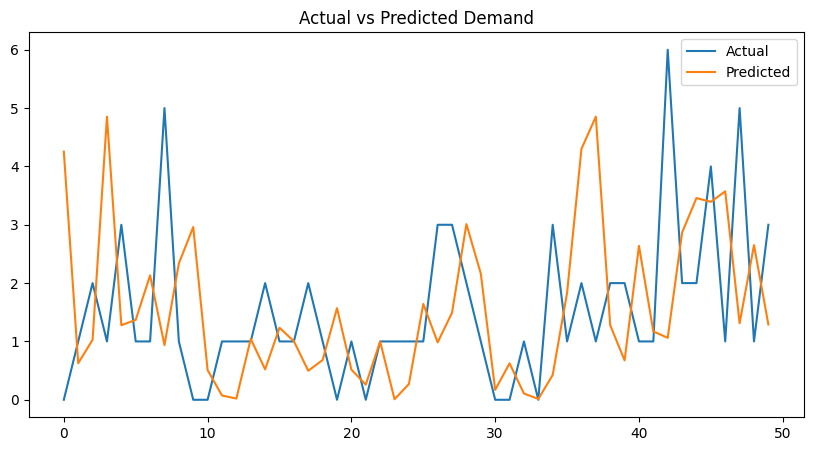

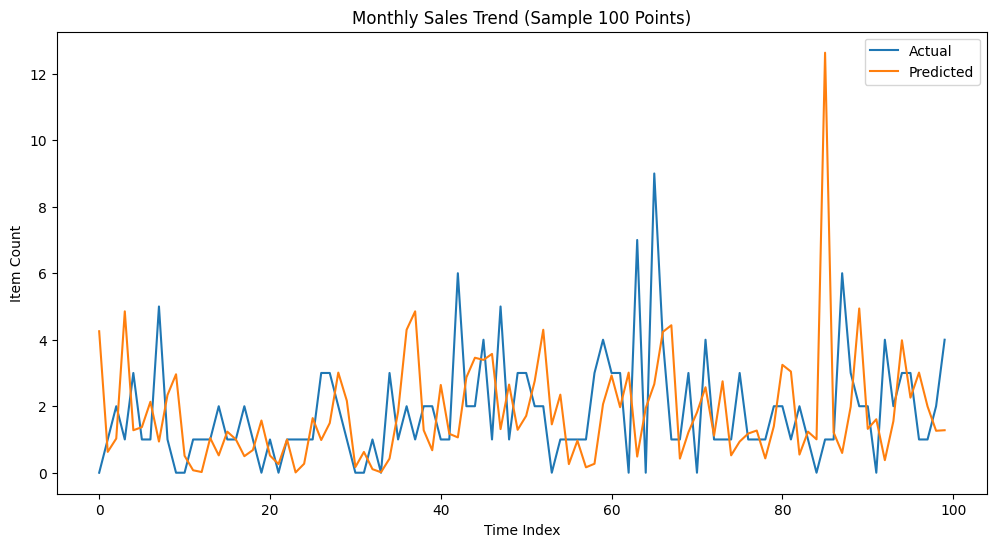

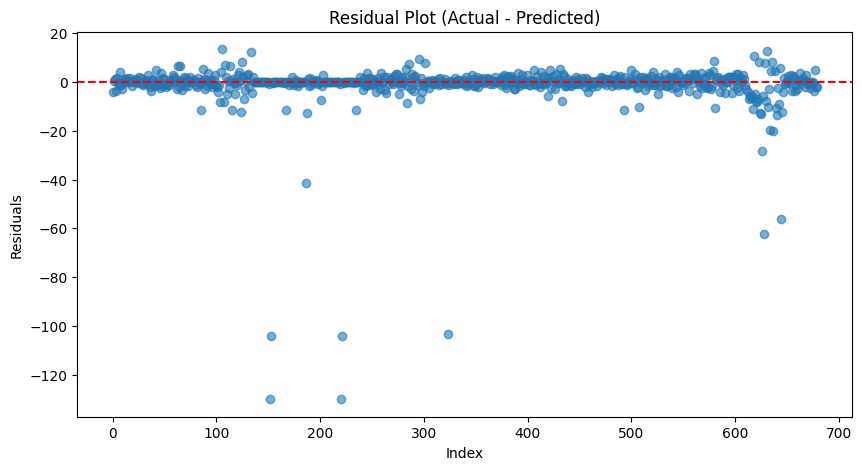

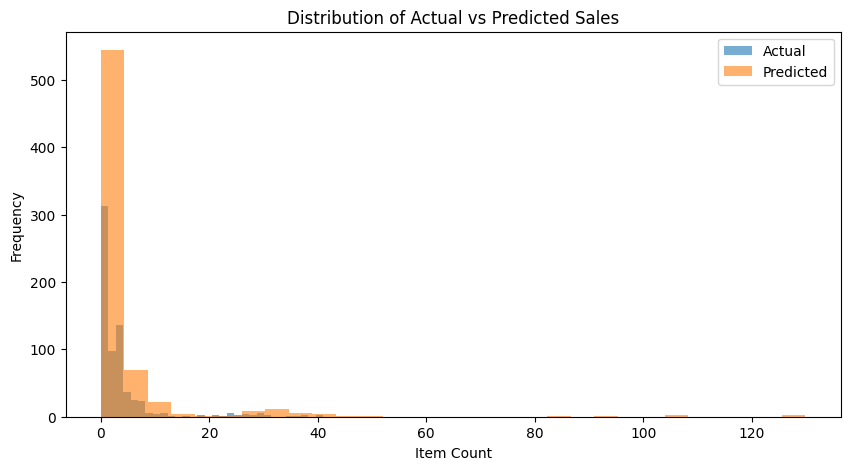

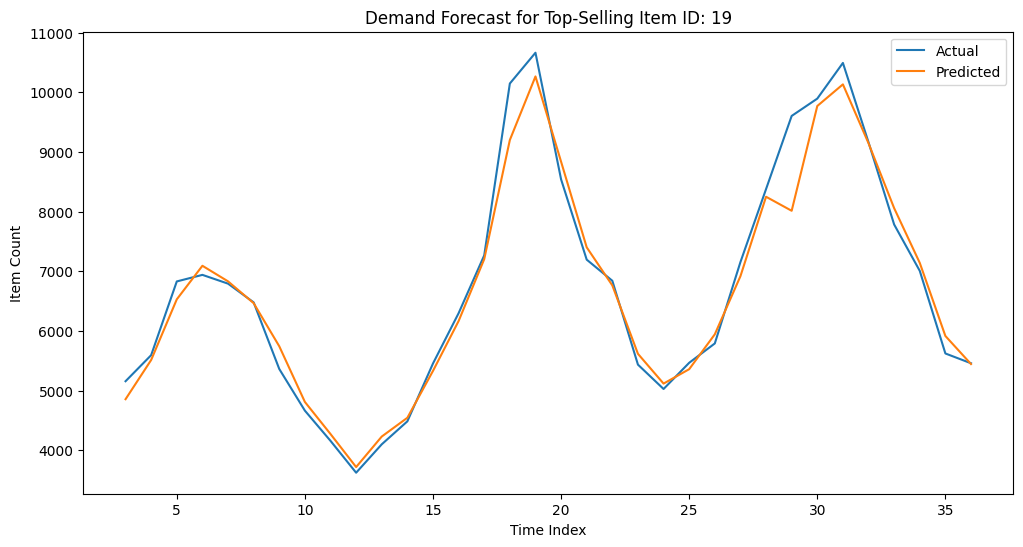

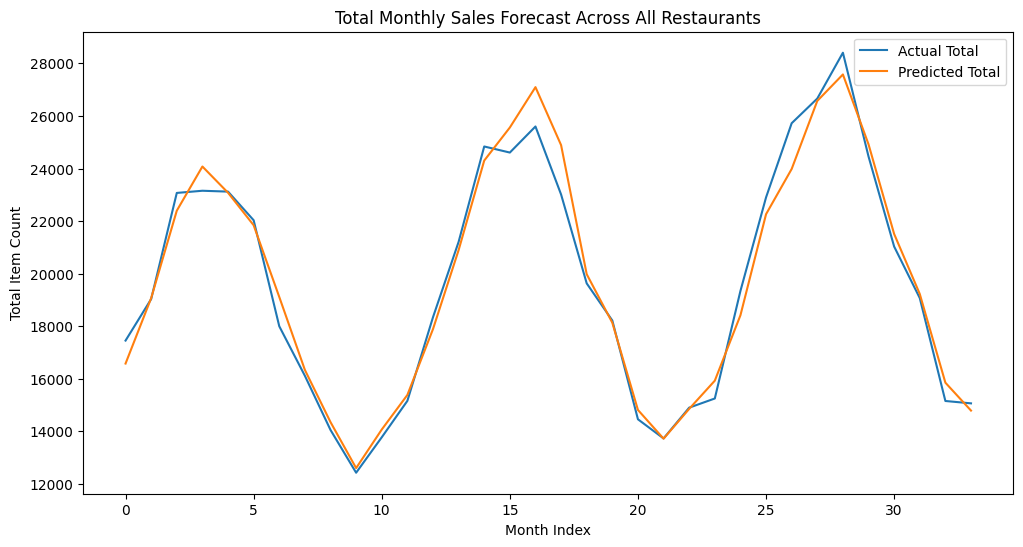

In [ ]:
#Visualization

#Predections
plt.figure(figsize=(10,5))
plt.plot(y_test.values[:50], label='Actual')
plt.plot(predictions[:50], label='Predicted')
plt.legend()
plt.title("Actual vs Predicted Demand")
plt.show()

#Monthly Sales Trend
monthly_actual = y_test.reset_index(drop=True)
monthly_predicted = pd.Series(predictions)
plt.figure(figsize=(12,6))
plt.plot(monthly_actual[:100], label='Actual')
plt.plot(monthly_predicted[:100], label='Predicted')
plt.title("Monthly Sales Trend (Sample 100 Points)")
plt.xlabel("Time Index")
plt.ylabel("Item Count")
plt.legend()
plt.show()

#Residual Plot
residuals = y_test.values - predictions

plt.figure(figsize=(10,5))
plt.scatter(range(len(residuals)), residuals, alpha=0.6)
plt.axhline(y=0, color='r', linestyle='--')
plt.title("Residual Plot (Actual - Predicted)")
plt.xlabel("Index")
plt.ylabel("Residuals")
plt.show()

#Distribution
plt.figure(figsize=(10,5))
plt.hist(y_test.values, bins=30, alpha=0.6, label='Actual')
plt.hist(predictions, bins=30, alpha=0.6, label='Predicted')
plt.title("Distribution of Actual vs Predicted Sales")
plt.xlabel("Item Count")
plt.ylabel("Frequency")
plt.legend()
plt.show()


# Top selling item
top_item_id = data.groupby('item_id')['item_count'].sum().idxmax()
top_item_data = data[data['item_id'] == top_item_id].sort_values('time_index')

plt.figure(figsize=(12,6))
plt.plot(top_item_data['time_index'], top_item_data['item_count'], label='Actual')
plt.plot(top_item_data['time_index'], model.predict(top_item_data[features]), label='Predicted')
plt.title(f"Demand Forecast for Top-Selling Item ID: {top_item_id}")
plt.xlabel("Time Index")
plt.ylabel("Item Count")
plt.legend()
plt.show()

#Total Monthly Sales
data['predicted'] = model.predict(data[features])
monthly_actual_sum = data.groupby(['year','month'])[['item_count','predicted']].sum().reset_index()
plt.figure(figsize=(12,6))
plt.plot(monthly_actual_sum.index, monthly_actual_sum['item_count'], label='Actual Total')
plt.plot(monthly_actual_sum.index, monthly_actual_sum['predicted'], label='Predicted Total')
plt.title("Total Monthly Sales Forecast Across All Restaurants")
plt.xlabel("Month Index")
plt.ylabel("Total Item Count")
plt.legend()
plt.show()


